In [1]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
import pandas as pd

import signature.tensor_algebra as ta

my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"])

## SPX / VIX data

In [39]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('2000-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [40]:
# pd.read_csv("spx_data.csv", index_col=0)
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)
#
# spx_data.index = pd.to_datetime(spx_data.index.date)
# vix_data.index = pd.to_datetime(vix_data.index.date)
#
# spx_data.to_csv("spx_data.csv", index=True)
# vix_data.to_csv("vix_data.csv", index=True)

In [41]:
spx_data = pd.read_csv("data/spx_data.csv", index_col=0)
vix_data = pd.read_csv("data/vix_data.csv", index_col=0)

spx_data.index = pd.to_datetime(spx_data.index)
vix_data.index = pd.to_datetime(vix_data.index)

In [42]:
index = spx_data.index
spx = spx_data['Close']
vix = vix_data['Close'] / 100

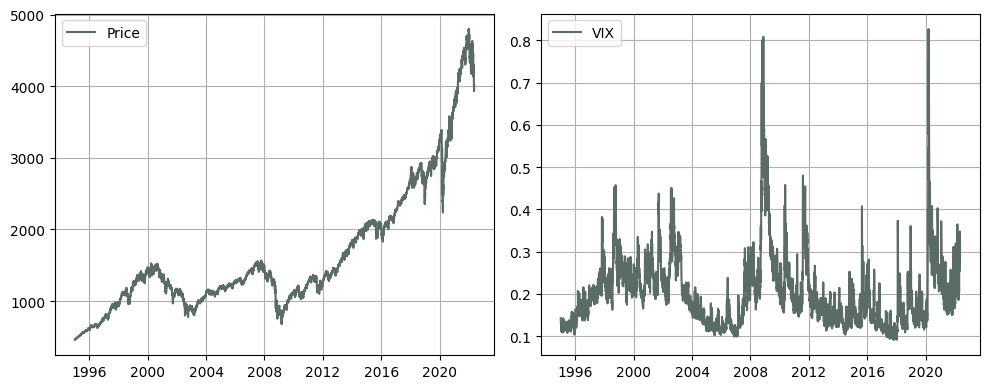

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

time_grid = np.array((index - train_start_date).days / 365)
dates_grid = pd.to_datetime(pd.Series(index))

ax[0].plot(dates_grid, spx, label="Price")
ax[0].legend()
# ax[1].plot(dates_grid, df_mkt.rv, label="RV")
ax[1].plot(dates_grid, vix, label="VIX")
ax[1].legend()

## EFM-Signature of returns

In [50]:
path = np.vstack([
    time_grid,
    np.log(spx),
    np.concatenate([[0], np.cumsum(np.diff(np.log(spx))**2)]),
]).T
dim = path.shape[1]
trunc = 3

In [46]:
def optimize_params(path, y, trunc, time_grid, model):
    dim = path.shape[1]

    def loss(x):
        StatSig = ta.path_to_fm_signature(path=path, trunc=trunc, t_grid=time_grid, lam=x)
        model.fit(StatSig.array.T, y)
        return mean_squared_error(y, model.predict(StatSig.array.T))

    optimizer = minimize(loss, x0=np.ones(dim) * 4, bounds=([0.00001, 50],) * dim,  method='Powell')
    return optimizer.x

In [47]:
in_sample_T = 18

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", Ridge(fit_intercept=True, alpha=0.001))
])

lam_opt = optimize_params(
    path=path[(index < test_start_date)],
    y=vix[(index >= train_start_date) & (index < test_start_date)],
    trunc=trunc,
    time_grid=time_grid[index < test_start_date],
    model=model
)
lam_opt

array([11.06876863, 11.88399087,  1.99704836])

MSE (train): 0.0003404555569017048 MSE (test): 0.0011040742183063546
R² (train): 0.9554184113221689 R² (test): 0.8564187036041826


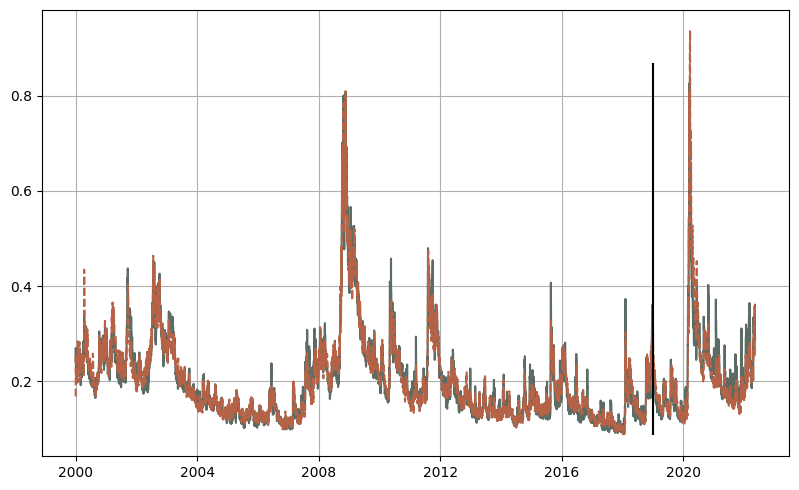

In [48]:
StatSig = ta.path_to_fm_signature(path=path, trunc=trunc, t_grid=time_grid, lam=lam_opt)

X = StatSig.array.T
y = vix[index >= train_start_date]
time_grid_stat = time_grid[index >= train_start_date]

X_train, y_train = X[time_grid_stat <= in_sample_T], y[time_grid_stat <= in_sample_T]
X_test, y_test = X[time_grid_stat > in_sample_T], y[time_grid_stat > in_sample_T]

model.fit(X_train, y_train)
vol_coef = ta.from_array(array=model["regressor"].coef_, dim=dim, trunc=trunc)
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(dates_grid[index >= train_start_date], y)
ax.plot(dates_grid[index >= train_start_date], y_pred, "--")
ax.vlines(x=test_start_date, ymin=0.95 * np.min(y), ymax=1.05 * np.max(y), color="k")

y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("MSE (train):", mse_train, "MSE (test):", mse_test)
print("R² (train):", r2_train, "R² (test):", r2_test)

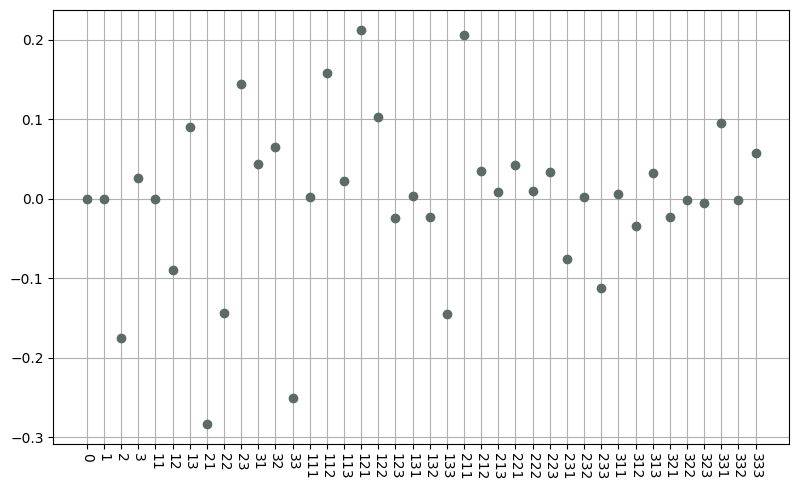

In [49]:
ta.plot_coefficients(vol_coef, trunc=trunc)